In [1]:
import sys
sys.path.append("..")

%load_ext autoreload
%autoreload 2

import torch
import gym_minigrid.wrappers
from gym import wrappers

from matplotlib import pyplot as plt
from src import utils as utils
from src.model import SimpleRecurrent
from src.algo import *

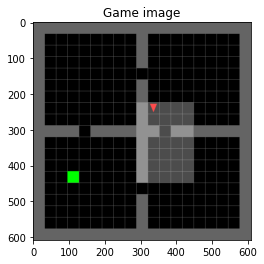

In [2]:
env_name = "MiniGrid-FourRooms-v0"
# env_name = "MiniGrid-Empty-8x8-v0"
# env = gym.make(env_name)
env = utils.make_env(env_name)

obs_space_shape = env.observation_space.shape
n_actions = env.action_space.n

plt.title('Game image')
plt.imshow(env.render('rgb_array'))
plt.show()

In [3]:
obs = env.reset()
agent = SimpleRecurrent(
    obs_space_shape,
    n_actions
)

In [4]:
state = [env.reset()]
_, (logits, value) = agent.step(agent.get_initial_state(1), state)
print("action logits:\n", logits)
print("state values:\n", value)

action logits:
 tensor([[ 0.0869, -0.1380, -0.0069,  0.1279, -0.3447,  0.0857, -0.0729]],
       grad_fn=<AddmmBackward>)
state values:
 tensor([0.0647], grad_fn=<SelectBackward>)


In [5]:
env_monitor = wrappers.Monitor(env, directory="videos", force=True)
rw = utils.evaluate(agent, env_monitor, n_games=10,)
env_monitor.close()

In [6]:
import wandb
from tqdm import tqdm
from src.algo import A2CAlgo

config = {
    "time": 100,
    "n_games_mean": 3,
    "max_reward": 2,
    "device": "cpu",
    "env": env_name
}

wandb.init(project="mlsh",
           monitor_gym=True,
           name="baseline",
           config=config)
wandb.watch(agent)


In [7]:
from src.env_pool import EnvPool
pool = EnvPool(agent, utils.make_env, 8)
rollout_obs, rollout_actions, rollout_rewards, rollout_mask = pool.interact(10)


In [8]:
print("Actions shape:", rollout_actions.shape)
print("Rewards shape:", rollout_rewards.shape)
print("Mask shape:", rollout_mask.shape)
print("Observations shape: ", rollout_obs.shape)

Actions shape: (8, 10)
Rewards shape: (8, 10)
Mask shape: (8, 10)
Observations shape:  (8, 10, 7, 7, 3)


In [9]:
alg = A2CAlgo(agent, config["device"], n_actions)
memory = list(pool.prev_memory_states)

for i in tqdm(range(10000)):
    memory = list(pool.prev_memory_states)
    rollout_obs, rollout_actions, rollout_rewards, rollout_mask = pool.interact(config["time"])
    loss, grad_norm, entropy = alg.train_on_rollout(
        rollout_obs, rollout_actions, rollout_rewards, rollout_mask, memory)

    reward = np.mean(utils.evaluate(agent, env, n_games=config["n_games_mean"]))

    if i % 20 == 0:
        log = {
            "rewards": reward,
            "grad_norm": grad_norm,
            "entropy": entropy,
            "loss": loss
        }
        wandb.log(log)

        if i % 200 == 0:
            env_monitor = wrappers.Monitor(env, directory="videos", force=True)
            rw = utils.evaluate(agent, env_monitor, n_games=config["n_games_mean"],)
            env_monitor.close()
        if reward  >= config["max_reward"]:
            print("Your agent has just passed the minimum homework threshold")
            break


  1%|          | 101/10000 [02:07<3:29:00,  1.27s/it]


KeyboardInterrupt: 